In [390]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_position, my_odometry


In [391]:
plt.rcParams['figure.figsize'] = [7, 7]

In [392]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [393]:
frame_rate = 10
n_samples = 200

env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate,
)

start_from_trajectory = True

# Trick to let the trajectory extractor see the whole line
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [394]:
dt = 1.0 / env.frame_rate

In [395]:
env.reset()
traj = utils.get_trajectory(env, samples=n_samples, method="distance", last_value_distance=1.035)
inside, outside = utils.get_border(traj, distance=0.1)

/home/giulio/prog/duckrace/utils.py:390: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [396]:
if start_from_trajectory:
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]
    # Why double? Good question
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]

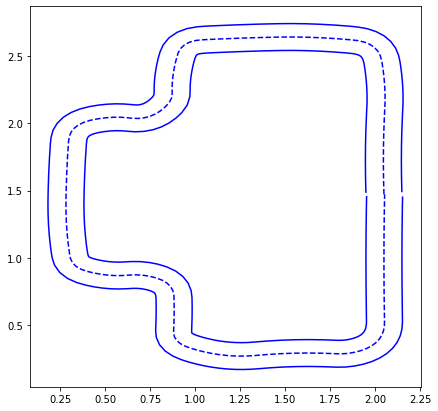

In [397]:
plt.plot(*traj.T, "b--")
plt.plot(*inside.T, "b-")
plt.plot(*outside.T, "b-")

Points wrt alpha:

In [398]:
insx = MX.sym('inside_x')
outx = MX.sym('outside_x')
a = MX.sym('alpha')

x = insx + a*(outx - insx)

Fx = Function('Fx',[insx, outx,  a],[x],['insx', 'outx', 'alpha'],['x'])

In [399]:
insy = MX.sym('inside_y')
outy = MX.sym('outside_y')
a = MX.sym('alpha')

y = insy + a*(outy - insy)

Fy = Function('Fy',[insy, outy, a],[y],['insy', 'outy', 'alpha'],['y'])

In [400]:
N = len(inside)
inside.shape

(199, 2)

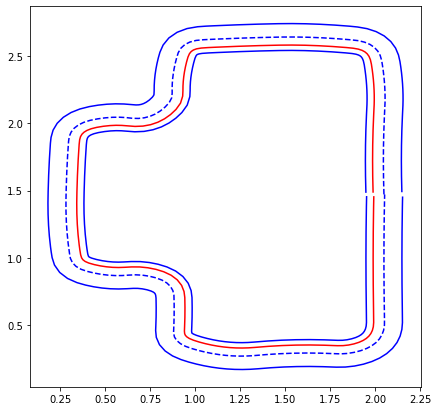

In [401]:
# Test
a = np.ones(N)*0.2
x = Fx(inside[:,0], outside[:,0], a)
y = Fx(inside[:,1], outside[:,1], a)

test = np.hstack([x,y])
plt.plot(*traj.T, "b--")
plt.plot(*inside.T, "b-")
plt.plot(*outside.T, "b-")
plt.plot(*test.T, "r-")

### Optimization

In [402]:
opti = Opti()

a = opti.variable(N)
x = opti.variable(N)
y = opti.variable(N)

insx = opti.parameter(N)
insy = opti.parameter(N)
outx = opti.parameter(N)
outy = opti.parameter(N)
Kl = opti.parameter(1)
Kp = opti.parameter(1)

ds2 = (x[2:]-x[1:-1])**2 + (y[2:]-y[1:-1])**2
obj = Kl*sum1( ds2 ) + Kp*sum1( (atan2(y[2:]-y[1:-1], x[2:]-x[1:-1]) - atan2(y[1:-1]-y[:-2], x[1:-1]-x[:-2]))/(ds2**0.5) )

opti.minimize(obj)

# Constraints Definition
opti.subject_to(x == Fx(insx, outx, a))
opti.subject_to(y == Fy(insy, outy, a))

opti.subject_to(a <= 1)
opti.subject_to(a >= -0.3)

opti.set_initial(a, np.ones(N)*0.5)
opti.set_initial(x, traj[:N,0])
opti.set_initial(y, traj[:N,1])

opti.set_value(insx, inside[:,0])
opti.set_value(insy, inside[:,1])
opti.set_value(outx, outside[:,0])
opti.set_value(outy, outside[:,1])
opti.set_value(Kl, 0.5)
opti.set_value(Kp, 0.5)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opts["verbose"] = False
opti.solver('ipopt',opts)

M = opti.to_function('M',[Kl, Kp],[x, y],['Kl', 'Kp'],['x', 'y'])

In [403]:
# If the track is too wide the interal line can get messy.
# For this reason min(alpha) < 0 and the track need to be recalculated
inside, outside = utils.get_border(traj, distance=0.17)

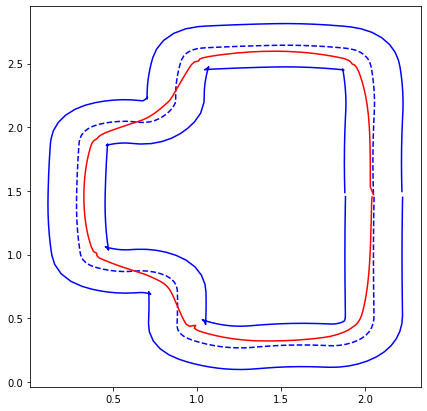

In [404]:
Kl = 1
Kp = 5e-6

xr, yr = M(Kl, Kp)

res = np.hstack([xr,yr])
res[0] = traj[0]
plt.plot(*traj.T, "b--")
plt.plot(*inside.T, "b-")
plt.plot(*outside.T, "b-")
plt.plot(*res.T, "r-")

In [405]:
ref = res
angles = np.zeros(ref.shape[0])
angles[:-1] = np.arctan2(ref[1:,1]-ref[:-1,1], ref[1:,0]-ref[:-1,0])
angles[-1] = np.arctan2(ref[0,1]-ref[-1,1], ref[0,0]-ref[-1,0])
ref = np.concatenate((ref, angles.reshape(-1,1)), axis=1)[::2]

In [406]:
# First loop
Mpc = Function.load('controllers/M_original.casadi')

N_MPC = 5

pose = get_position(env)
distance,index = spatial.KDTree(ref[:,:2]).query([pose.x, pose.y])
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
r0 = ref[index:index+N_MPC+1, :2].T
t0 = ref[index:index+N_MPC+1, 2].T

# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
starting_y = pose.y
r = r0
tr = t0
idx = index
u_delay = u_delay0

kdtree = spatial.KDTree(ref[:, :2])

t = 0
while True:
    u = Mpc(x, r, tr, u_delay,  1e3, 1e2, 1, 0)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (ref[idx, 0] - x[0])**2 + (ref[idx, 1] - x[1])**2

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    if idx+N_MPC+1 < ref.shape[0]:
        r = ref[idx:idx+N_MPC+1, :2].T
        tr = ref[idx:idx+N_MPC+1, 2].T
    else:
        r = vertcat(ref[idx:, :2], ref[:idx+N_MPC+1-ref.shape[0], :2]).T
        tr = vertcat(ref[idx:, 2], ref[:idx+N_MPC+1-ref.shape[0], 2]).T

    if ref[idx, 1] >= starting_y and t >= 10*env.frame_rate:
        break
    t += 1

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(*traj.T, "k--")
ax_dict["A"].plot(*inside.T, "k-")
ax_dict["A"].plot(*outside.T, "k-")
ax_dict["A"].plot(ref[:,0], ref[:,1], "b")
ax_dict["A"].plot(ref[index,0], ref[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(ref[idx, 0], ref[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [ ]:
f"Time per lap: {X_log.shape[1]*dt}s"

13.3